In [1]:
%%time
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv


@dataclass
class Config:
    project_dir: Path = Path("../../")
    model_dir: Path = project_dir / "models"
    outputs_dir: Path = project_dir / "outputs"
    results_dir: Path = project_dir / "results"
    results_agg_dir: Path = results_dir / "agg"
    results_figs_dir: Path = results_dir / "figs"
    data_dir: Path = project_dir / "data"
    raw_dir: Path = data_dir / "raw"
    interim_dir: Path = data_dir / "interim"
    processed_dir: Path = data_dir / "processed"


config = Config()
sys.path.append(str(config.project_dir.resolve()))
load_dotenv()

CPU times: user 1.47 s, sys: 428 ms, total: 1.9 s
Wall time: 13.6 s


False

In [2]:
df_order_info_details = pd.read_csv(config.processed_dir / "order_info_details.csv")
df_reviews = pd.read_csv(
    config.interim_dir
    / "olist_order_reviews_translated_label_review_categories_merged.csv",
)
df_reviews_last = df_reviews.groupby("order_id").last().reset_index()
df_order_info_details_reviews_merged = pd.merge(
    df_order_info_details, df_reviews_last, on="order_id", how="left"
)
assert df_order_info_details_reviews_merged.shape[0] == df_order_info_details.shape[0]
for col in [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "shipping_limit_date",
]:
    df_order_info_details_reviews_merged[col] = pd.to_datetime(
        df_order_info_details_reviews_merged[col],
        format="mixed",
    )
df_review_no_null = df_order_info_details_reviews_merged.dropna(
    subset=["review_comment_message_en"]
)
print(f"df_review_no_null.shape: {df_review_no_null.shape}")


df_review_no_null.shape: (40818, 90)


In [3]:
df_review_about_delivery = df_review_no_null[
    [
        "order_id",
        "product_category_name_english",
        "review_categories_str",
        "order_approved_span_hours_from_purchase",
        "order_estimated_delivery_span_hours_from_purchase",
        "order_delivered_customer_span_hours_from_purchase",
        "order_delivered_carrier_span_hours_from_approval",
        "order_shipping_limit_span_hours_from_purchase",
        "order_estimated_delivery_span_hours_from_shipping_limit",
        "order_delivered_customer_span_hours_from_carrier",
    ]
].query("review_categories_str in ['Delivery_Issue','Delivery_Praise']")

In [4]:
print("Estimation")
df_review_about_delivery.groupby("review_categories_str").agg(
    {
        "order_estimated_delivery_span_hours_from_purchase": "mean",
        "order_shipping_limit_span_hours_from_purchase": "mean",
        "order_estimated_delivery_span_hours_from_shipping_limit": "mean",
    }
)


Estimation


,order_estimated_delivery_span_hours_from_purchase,order_shipping_limit_span_hours_from_purchase,order_estimated_delivery_span_hours_from_shipping_limit
review_categories_str,,,
Delivery_Issue,604.492826,170.398967,435.762524
Delivery_Praise,563.878956,154.407390,409.371646


In [5]:
print("Actual Time Taken")
df_review_about_delivery.groupby("review_categories_str").agg(
    {
        "order_approved_span_hours_from_purchase": "mean",
        "order_delivered_customer_span_hours_from_purchase": "mean",
        "order_delivered_carrier_span_hours_from_approval": "mean",
        "order_delivered_customer_span_hours_from_carrier": "mean",
    }
)

Actual Time Taken


,order_approved_span_hours_from_purchase,order_delivered_customer_span_hours_from_purchase,order_delivered_carrier_span_hours_from_approval,order_delivered_customer_span_hours_from_carrier
review_categories_str,,,,
Delivery_Issue,12.356038,580.406563,105.085525,462.253785
Delivery_Praise,10.183448,240.281657,55.708637,174.356590


In [9]:
# Convert actual time data to long format
df_melted_actual = df_review_about_delivery.melt(
    id_vars=["review_categories_str"],
    value_vars=[
        "order_approved_span_hours_from_purchase",
        "order_delivered_carrier_span_hours_from_approval",
        "order_delivered_customer_span_hours_from_carrier",
    ],
)
# Convert estimated time data to long format
df_melted_estimated = df_review_about_delivery.melt(
    id_vars=["review_categories_str"],
    value_vars=[
        "order_shipping_limit_span_hours_from_purchase",
        "order_estimated_delivery_span_hours_from_purchase",
    ],
)
# Dictionary to translate variable names to Japanese
var_names_actual = {
    "order_approved_span_hours_from_purchase": "Time from \n purchase to order approval",
    "order_delivered_carrier_span_hours_from_approval": "Time from \n  order approval to delivery carrier",
    "order_delivered_customer_span_hours_from_carrier": "Time from \n  delivery carrier to customer",
}

var_names_estimated = {
    "order_shipping_limit_span_hours_from_purchase": "Time from \n  purchase to shipping limit",
    "order_estimated_delivery_span_hours_from_purchase": "Estimated time from \n  purchase to delivery",
}
# Translate variable names to English
df_melted_actual["variable"] = df_melted_actual["variable"].map(var_names_actual)
df_melted_estimated["variable"] = df_melted_estimated["variable"].map(
    var_names_estimated
)

# Set the order of the hue
hue_order = ["Delivery_Praise", "Delivery_Issue"]

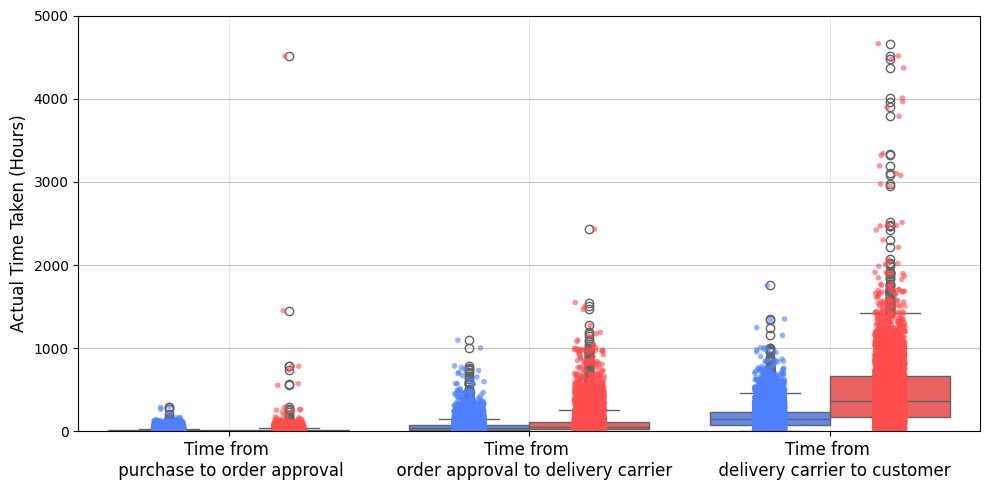

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
light_blue = (0.3, 0.5, 1.0, 0.6)
light_red = (1.0, 0.3, 0.3, 0.6)
sns.boxplot(
    data=df_melted_actual,
    x="variable",
    y="value",
    hue="review_categories_str",
    hue_order=hue_order,
    palette={"Delivery_Praise": light_blue, "Delivery_Issue": light_red},
    width=0.8,
    ax=ax,
    legend=False,
)
sns.stripplot(
    data=df_melted_actual,
    x="variable",
    y="value",
    hue="review_categories_str",
    hue_order=hue_order,
    dodge=True,
    size=4,
    palette={"Delivery_Praise": light_blue, "Delivery_Issue": light_red},
    ax=ax,
    legend=False,
)
ax.set_xlabel("")
ax.set_ylabel("Actual Time Taken (Hours)", fontsize=12)
plt.tick_params(axis="x", labelsize=12)
ax.grid(axis="x", linestyle="-", alpha=0.3)
ax.grid(axis="y", linestyle="-", alpha=0.7)
ax.set_ylim(0, 5000)
plt.tight_layout()
plt.savefig(config.results_figs_dir / "delivery_issue_analysis_actual.png")
plt.show()

In [15]:
df_melted_actual.groupby(
    [
        "variable",
        "review_categories_str",
    ]
)["value"].describe().to_csv(
    config.results_agg_dir / "delivery_issue_analysis_actual_describe.csv"
)

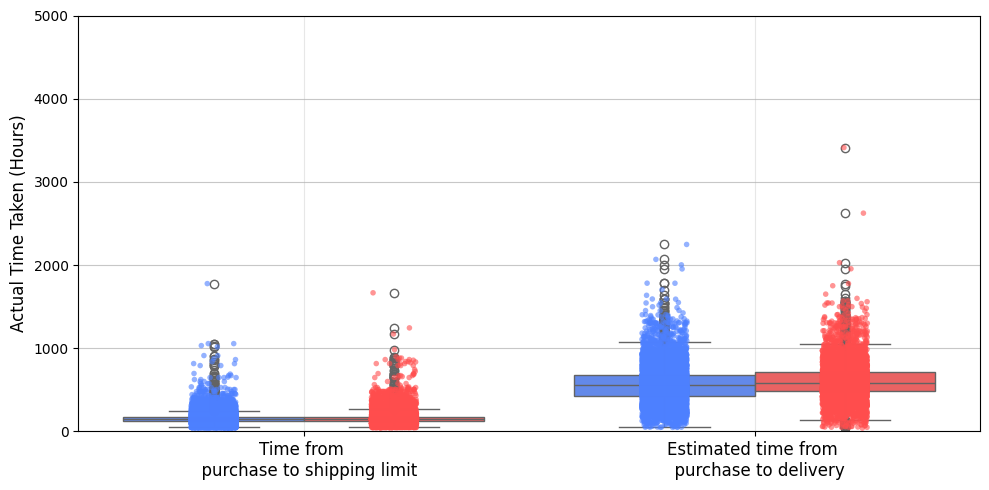

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
light_blue = (0.3, 0.5, 1.0, 0.6)
light_red = (1.0, 0.3, 0.3, 0.6)
sns.boxplot(
    data=df_melted_estimated,
    x="variable",
    y="value",
    hue="review_categories_str",
    palette={"Delivery_Praise": light_blue, "Delivery_Issue": light_red},
    hue_order=hue_order,
    width=0.8,
    ax=ax,
    legend=False,
)
sns.stripplot(
    data=df_melted_estimated,
    x="variable",
    y="value",
    hue="review_categories_str",
    hue_order=hue_order,
    dodge=True,
    size=4,
    palette={"Delivery_Praise": light_blue, "Delivery_Issue": light_red},
    ax=ax,
    legend=False,
)
ax.set_xlabel("")
plt.tick_params(axis="x", labelsize=12)
ax.set_ylabel("Actual Time Taken (Hours)", fontsize=12)
ax.grid(axis="x", linestyle="-", alpha=0.3)
ax.grid(axis="y", linestyle="-", alpha=0.7)
ax.set_ylim(0, 5000)
plt.tight_layout()
plt.savefig(config.results_figs_dir / "delivery_issue_analysis_estimated.png")
plt.show()

In [16]:
df_melted_estimated.groupby(
    [
        "variable",
        "review_categories_str",
    ]
)["value"].describe().to_csv(
    config.results_agg_dir / "delivery_issue_analysis_estimated_describe.csv"
)